In [1]:
import polars as pl
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.multitest import multipletests

In [2]:
# -----------------------------
# Load parquet files
# -----------------------------

raf = pl.read_parquet("../evaluation/raf/movie_emotion_summary.parquet")
best = pl.read_parquet("../evaluation/pixa_v2/movie_emotion_summary.parquet")

raf = raf.with_columns(pl.lit("raf").alias("model"))
best = best.with_columns(pl.lit("best").alias("model"))
best = best[raf.columns]

df = pl.concat([raf, best])


In [3]:
# -----------------------------
# Keep only needed columns
# -----------------------------

emotion_cols = [
    "angry_pct", "fear_pct", "happy_pct",
    "sad_pct", "surprise_pct"
]

df = df.select(
    ["movie", "model"] + emotion_cols
)


In [4]:
# -----------------------------
# Load your genre JSON
# -----------------------------

genre_map = pd.read_json("movie_list.json")

# merge
df = df.to_pandas()
df = df.merge(
    genre_map,
    left_on="movie",
    right_on="file_name",
    how="left"
)

df = df.drop(columns=["file_name"])


In [5]:
df.head()

,movie,model,angry_pct,fear_pct,happy_pct,sad_pct,surprise_pct,title,category
0,real_steel,raf,7.658960,5.346821,20.664740,26.734104,39.595376,Real Steel,Sci-Fi
1,point_break,raf,11.339093,1.511879,24.298056,30.021598,32.829374,Point Break,Action
2,jurassic_world,raf,10.000000,3.253012,14.939759,26.385542,45.421687,Jurassic World,Sci-Fi
3,iron_man_3,raf,11.712707,8.618785,16.243094,32.707182,30.718232,Iron Man 3,Action
4,lotr_3,raf,7.680723,2.560241,12.123494,50.602410,27.033133,The Lord of the Rings: The Return of the King,Fantasy


In [6]:
genre_map

,file_name,title,category
0,2_guns,2 Guns,Action
1,300,300,Action
2,47_ronin,47 Ronin,Action
3,9,9,Animation
4,airplane,Airplane!,Comedy
5,amazing_spider-man_the,The Amazing Spider-Man,Action
6,avengers_age_of_ultron,Avengers: Age of Ultron,Action
7,big_hero_6,Big Hero 6,Animation
8,black_mass,Black Mass,Crime
9,blackkklansman,BlacKkKlansman,Crime


In [7]:
def paired_test(df, genre, emotion):

    sub = df[df["category"] == genre]
    
    raf = (
        sub[sub.model == "raf"]
        .sort_values("movie")[emotion]
        .values
    )
    
    best = (
        sub[sub.model == "best"]
        .sort_values("movie")[emotion]
        .values
    )
    
    diff = best - raf
    
    t_stat, p_t = ttest_rel(best, raf)
    w_stat, p_w = wilcoxon(best, raf)
    
    # Cohen's d (paired)
    d = diff.mean() / diff.std(ddof=1)
    
    # Bootstrap CI
    boots = []
    for _ in range(5000):
        sample = np.random.choice(diff, size=len(diff), replace=True)
        boots.append(sample.mean())
    ci_low, ci_high = np.percentile(boots, [2.5, 97.5])
    
    return {
        "genre": genre,
        "emotion": emotion,
        "n": len(diff),
        "mean_diff": diff.mean(),
        "cohens_d": d,
        "t_p": p_t,
        "wilcoxon_p": p_w,
        "ci_low": ci_low,
        "ci_high": ci_high
    }


In [8]:
df.head()

,movie,model,angry_pct,fear_pct,happy_pct,sad_pct,surprise_pct,title,category
0,real_steel,raf,7.658960,5.346821,20.664740,26.734104,39.595376,Real Steel,Sci-Fi
1,point_break,raf,11.339093,1.511879,24.298056,30.021598,32.829374,Point Break,Action
2,jurassic_world,raf,10.000000,3.253012,14.939759,26.385542,45.421687,Jurassic World,Sci-Fi
3,iron_man_3,raf,11.712707,8.618785,16.243094,32.707182,30.718232,Iron Man 3,Action
4,lotr_3,raf,7.680723,2.560241,12.123494,50.602410,27.033133,The Lord of the Rings: The Return of the King,Fantasy


In [9]:
results = []

for genre in df.category.unique():
    for emotion in emotion_cols:
        results.append(
            paired_test(df, genre, emotion)
        )

results_df = pd.DataFrame(results)

# FDR correction (recommended)
results_df["p_adj"] = multipletests(
    results_df["wilcoxon_p"],
    method="fdr_bh"
)[1]

results_df.sort_values("p_adj")


/home/dxd/anaconda3/envs/faces/lib/python3.14/site-packages/scipy/stats/_stats_py.py:1251: RuntimeWarning: divide by zero encountered in divide
  var *= (n / (n-ddof))  # to avoid error on division by zero
/home/dxd/anaconda3/envs/faces/lib/python3.14/site-packages/scipy/stats/_stats_py.py:1251: RuntimeWarning: invalid value encountered in scalar multiply
  var *= (n / (n-ddof))  # to avoid error on division by zero
/home/dxd/anaconda3/envs/faces/lib/python3.14/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dxd/anaconda3/envs/faces/lib/python3.14/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,genre,emotion,n,mean_diff,cohens_d,t_p,wilcoxon_p,ci_low,ci_high,p_adj
6,Action,fear_pct,17,32.755771,3.393076,2.163052e-10,0.000015,28.355207,37.302128,0.000267
9,Action,surprise_pct,17,-31.868467,-5.081300,4.670631e-13,0.000015,-34.781348,-28.949038,0.000267
11,Fantasy,fear_pct,11,36.258174,2.934964,2.033662e-06,0.000977,29.575088,43.330494,0.008545
14,Fantasy,surprise_pct,11,-30.472972,-4.439306,4.180184e-08,0.000977,-34.242951,-26.659066,0.008545
12,Fantasy,happy_pct,11,-5.739749,-1.677776,2.391971e-04,0.001953,-7.586350,-3.783178,0.009766
16,Comedy,fear_pct,10,19.333362,1.746565,3.689935e-04,0.001953,14.274408,26.512126,0.009766
19,Comedy,surprise_pct,10,-33.115162,-5.342637,3.998563e-08,0.001953,-36.656698,-29.576067,0.009766
10,Fantasy,angry_pct,11,6.318281,1.114437,4.134529e-03,0.002930,3.141942,9.450758,0.012817
26,Crime,fear_pct,7,33.188581,2.605902,4.597739e-04,0.015625,24.330532,41.867704,0.042067
18,Comedy,sad_pct,10,7.975045,0.751127,4.154850e-02,0.013672,2.211022,14.554502,0.042067


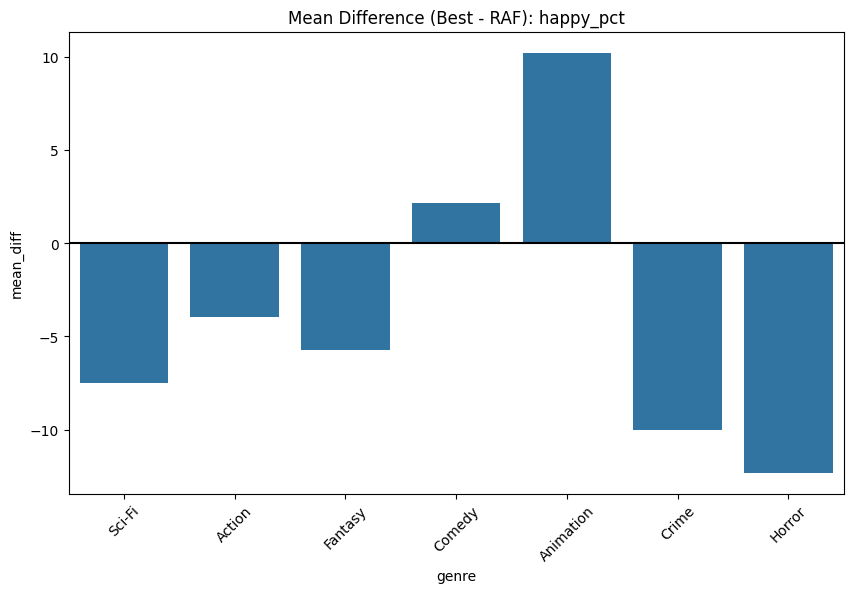

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

emotion = "happy_pct"

plot_df = results_df[results_df.emotion == emotion]

plt.figure(figsize=(10,6))
sns.barplot(
    data=plot_df,
    x="genre",
    y="mean_diff"
)

plt.axhline(0, color="black")
plt.title(f"Mean Difference (Best - RAF): {emotion}")
plt.xticks(rotation=45)
plt.show()


In [11]:
print(results_df.to_markdown())

|    | genre     | emotion      |   n |   mean_diff |     cohens_d |           t_p |   wilcoxon_p |     ci_low |    ci_high |       p_adj |
|---:|:----------|:-------------|----:|------------:|-------------:|--------------:|-------------:|-----------:|-----------:|------------:|
|  0 | Sci-Fi    | angry_pct    |   7 |   6.46542   |   0.591529   |   0.16861     |  0.21875     |  -0.658474 |  14.3139   | 0.31901     |
|  1 | Sci-Fi    | fear_pct     |   7 |  33.3732    |   3.99364    |   4.22745e-05 |  0.015625    |  27.2152   |  38.9122   | 0.0420673   |
|  2 | Sci-Fi    | happy_pct    |   7 |  -7.47327   |  -1.50428    |   0.00728357  |  0.03125     | -10.567    |  -3.80706  | 0.0643382   |
|  3 | Sci-Fi    | sad_pct      |   7 |   3.75676   |   0.400476   |   0.330124    |  0.296875    |  -2.21933  |  10.7662   | 0.399639    |
|  4 | Sci-Fi    | surprise_pct |   7 | -36.1222    |  -6.77785    |   1.93365e-06 |  0.015625    | -39.4756   | -32.2891   | 0.0420673   |
|  5 | Action    | a

In [12]:
results_df

,genre,emotion,n,mean_diff,cohens_d,t_p,wilcoxon_p,ci_low,ci_high,p_adj
0,Sci-Fi,angry_pct,7,6.465416,0.591529,1.686103e-01,0.218750,-0.658474,14.313893,0.319010
1,Sci-Fi,fear_pct,7,33.373243,3.993641,4.227451e-05,0.015625,27.215223,38.912211,0.042067
2,Sci-Fi,happy_pct,7,-7.473270,-1.504284,7.283568e-03,0.031250,-10.566995,-3.807058,0.064338
3,Sci-Fi,sad_pct,7,3.756765,0.400476,3.301240e-01,0.296875,-2.219332,10.766158,0.399639
4,Sci-Fi,surprise_pct,7,-36.122153,-6.777853,1.933647e-06,0.015625,-39.475623,-32.289145,0.042067
5,Action,angry_pct,17,4.342754,0.476337,6.714885e-02,0.071411,0.341305,8.852906,0.131547
6,Action,fear_pct,17,32.755771,3.393076,2.163052e-10,0.000015,28.355207,37.302128,0.000267
7,Action,happy_pct,17,-3.957013,-0.391046,1.264392e-01,0.063828,-8.336614,0.887143,0.124109
8,Action,sad_pct,17,-1.273045,-0.131204,5.959810e-01,0.853638,-5.891358,2.979306,1.000000
9,Action,surprise_pct,17,-31.868467,-5.081300,4.670631e-13,0.000015,-34.781348,-28.949038,0.000267


In [13]:
results_df.to_csv('ttest_results.csv')

In [14]:
results_df['genre'].unique()

array(['Sci-Fi', 'Action', 'Fantasy', 'Comedy', 'Animation', 'Crime',
       'Horror'], dtype=object)

In [15]:
comedies = genre_map[genre_map['category']=="Comedy"]

In [16]:
comedies['file_name'].to_list()

['airplane',
 'dark_shadows',
 'dazed_and_confused',
 'dodgeball',
 'gaffigan_kingbaby',
 'hitchhikersguidetothegalaxy',
 'hot_fuzz',
 'old_school',
 'pineapple_exp',
 'scott_pilgrim']

In [17]:
comedies.shape

(10, 3)